In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nsteps = 100
#sg = 0 # starting grad
#sm = 0.2 # starting momentum
das = [0.2,0.2] # default injected grad
dps = [0,1] # default positions
mdecay = 0.9
b1 = 0.9
b2 = 0.999
alpha = 0.99
eps = 1e-8

In [3]:

def opt_plot(opt, grad_injection_points, 
             grad_injection_mags, nsteps=100, 
             output_terms=False):
    updates = []
    new_grads= np.zeros(nsteps)
    for ind in range(len(grad_injection_points)):
        new_grads[grad_injection_points[ind]]=grad_injection_mags[ind]
    mt = 0
    vt=0
    
    if output_terms: 
        # need to store the terms that are moving around!
        mts = []
        vts = []
        hvt=0
    
    for s in np.arange(nsteps):
        if opt== 'sgdm':
            mt = mdecay*mt+new_grads[s]
            final=mt
            
            hmt=mt # for output logging
            
        elif opt=='adam':
            mt = b1*mt+(1-b1)*new_grads[s]
            vt = b2*vt+(1-b2)*(new_grads[s]**2)
            hmt = mt/(1-b1)
            hvt = vt/(1-b2)
            final = hmt/(np.sqrt(hvt)+eps)
            
        elif opt=='rmsprop':
            vt = alpha*vt+(1-alpha)*(new_grads[s]**2)
            hmt = new_grads[s]
            hvt = vt
            final = new_grads[s]/(np.sqrt(vt)+eps)
            
        else:
            raise NotImplementedError()
        
        updates.append(final)
        
        if output_terms: 
            mts.append(hmt)
            vts.append(hvt)
        
    if output_terms: 
        return updates, mts, vts
    
    return updates

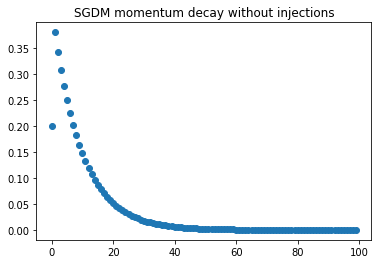

In [4]:
updates = opt_plot('sgdm', dps, das)
plt.scatter(range(nsteps), updates)
plt.title("SGDM momentum decay without injections")
plt.show()

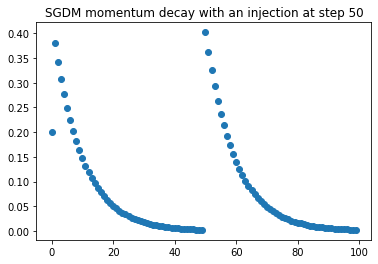

In [5]:
updates = opt_plot('sgdm',dps+[50],
                    das+[0.4])
plt.scatter(range(nsteps), updates)
plt.title("SGDM momentum decay with an injection at step 50")
plt.show()

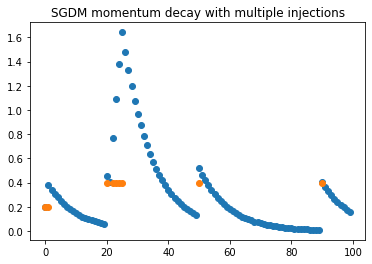

In [6]:
gjs = [20,22,23,24,25,50,90]
updates = opt_plot('sgdm', dps+gjs,
                    das+[0.4]*len(gjs))
plt.scatter(range(nsteps), updates)

plt.scatter(dps+gjs, das+[0.4]*len(gjs))

plt.title("SGDM momentum decay with multiple injections")
plt.show()

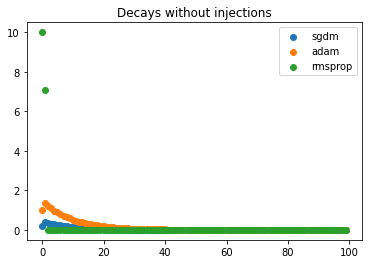

In [7]:
s_updates = opt_plot('sgdm', dps, das)
plt.scatter(range(nsteps), s_updates, label='sgdm')

a_updates = opt_plot('adam', dps, das)
plt.scatter(range(nsteps), a_updates, label='adam')
r_updates = opt_plot('rmsprop', dps, das)
plt.scatter(range(nsteps), r_updates, label='rmsprop')
plt.title("Decays without injections")
plt.legend()
plt.show()

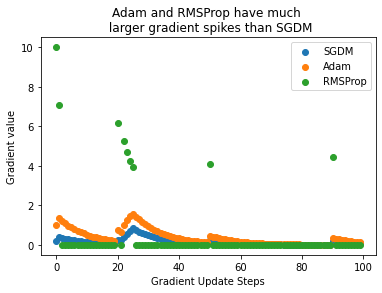

In [8]:
new_points = [20,22,23,24,25,50,90]

ips = dps+new_points   #injection points
ias = das+[0.2]*len(new_points)# injection amounts

s_updates = opt_plot('sgdm', ips, ias)
plt.scatter(range(nsteps), s_updates, label='SGDM')

a_updates = opt_plot('adam', ips, ias)
plt.scatter(range(nsteps), a_updates, label='Adam')

r_updates = opt_plot('rmsprop', ips, ias)
plt.scatter(range(nsteps), r_updates, label='RMSProp')

plt.title("Adam and RMSProp have much \n larger gradient spikes than SGDM")
plt.legend()
plt.xlabel("Gradient Update Steps")
plt.ylabel("Gradient value")
#plt.yscale('log')
plt.gcf().savefig("StaleGradSpikes.png",dpi=250)
plt.show()

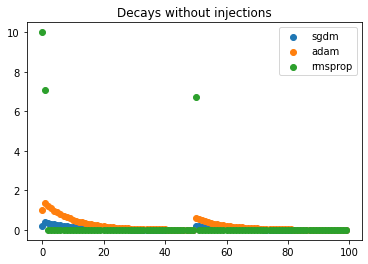

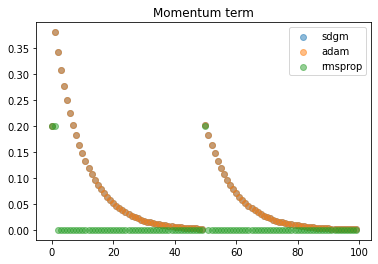

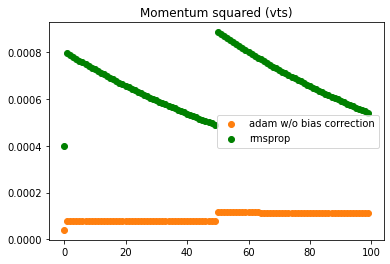

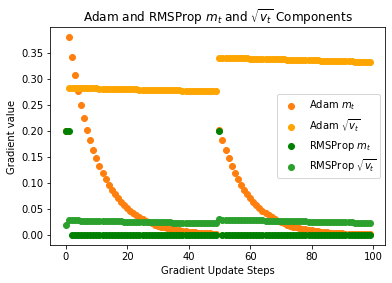

In [9]:
new_points = [50]
ips = dps+new_points   #injection points
ias = das+[0.2]*len(new_points)# injection amounts
# [0.01,0.01]+[0.01]*len(new_points)# gives the same results as all relative
s_updates, s_mts, s_vts = opt_plot('sgdm', ips, 
                                   ias, output_terms=True)
plt.scatter(range(nsteps), s_updates, label='sgdm')

a_updates, a_mts, a_vts = opt_plot('adam', ips, 
                                   ias, output_terms=True)
plt.scatter(range(nsteps), a_updates, label='adam')

r_updates, r_mts, r_vts = opt_plot('rmsprop', ips, ias, output_terms=True)
plt.scatter(range(nsteps), r_updates, label='rmsprop')

plt.title("Decays without injections")
plt.legend()
plt.show()

plt.scatter(range(nsteps), s_mts, label='sdgm', alpha=0.5)
plt.scatter(range(nsteps), a_mts, label='adam', alpha=0.5)
plt.scatter(range(nsteps), r_mts, label='rmsprop', alpha=0.5)
plt.title("Momentum term")
plt.legend()
plt.show()

plt.scatter(range(nsteps),np.asarray(a_vts)*(1-b2), label='adam w/o bias correction', color='tab:orange')
plt.scatter(range(nsteps),r_vts, label='rmsprop', color='green')
plt.legend()
plt.title("Momentum squared (vts)")
plt.show()

plt.scatter(range(nsteps),a_mts,label='Adam $m_t$', color='tab:orange' )
plt.scatter(range(nsteps),np.sqrt(a_vts), label='Adam '+'$\sqrt{v_t}$', color='orange' )
plt.title("Adam $m_t$ and $sqrt(v_t)$")
#plt.legend()
#plt.show()

plt.scatter(range(nsteps),r_mts,label='RMSProp $m_t$', color='green' )
plt.scatter(range(nsteps),np.sqrt(r_vts), label='RMSProp $\sqrt{v_t}$',color='tab:green' )
plt.title("Adam and RMSProp $m_t$ and $\sqrt{v_t}$ Components")
plt.legend()
plt.xlabel("Gradient Update Steps")
plt.ylabel("Gradient value")
plt.gcf().savefig("AdamNRMSPropComponents.png",dpi=250)
plt.show()


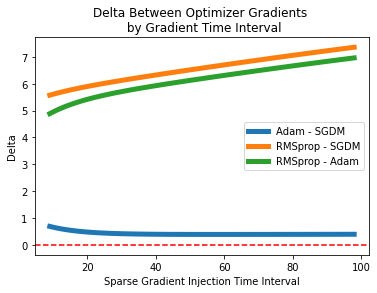

In [10]:
# deltas based upon the time gaps
injection_points = np.arange(10,100).astype(int)-1
deltas = []
for i in injection_points:
    new_points = [i]
    ips = dps+new_points   #injection points
    ias = das+[0.2]*len(new_points)# injection amounts

    s_updates, s_mts, s_vts = opt_plot('sgdm', ips, 
                                       ias, output_terms=True)

    a_updates, a_mts, a_vts = opt_plot('adam', ips, 
                                       ias, output_terms=True)
    
    r_updates, r_mts, r_vts = opt_plot('rmsprop', ips, 
                                       ias, output_terms=True)
    
    sgd_adam_delta = a_updates[i] - s_updates[i]
    sgd_rms_delta = r_updates[i] - s_updates[i]
    rms_adam_delta = r_updates[i] - a_updates[i] 
    deltas.append((sgd_adam_delta,
                  sgd_rms_delta,
                  rms_adam_delta))
plt.plot(injection_points, [d[0] for d in deltas],
           label='Adam - SGDM', linewidth=5)
plt.plot(injection_points, [d[1] for d in deltas],
           label='RMSprop - SGDM', linewidth=5)
plt.plot(injection_points, [d[2] for d in deltas],
           label='RMSprop - Adam', linewidth=5)
plt.legend()
plt.title("Delta Between Optimizer Gradients \n by Gradient Time Interval")
plt.xlabel("Sparse Gradient Injection Time Interval")
plt.ylabel("Delta")
plt.axhline(0.0, color='red', linestyle='dashed')
plt.gcf().savefig("StaleGradDeltas_Pairwise.png",dpi=250)
plt.show()

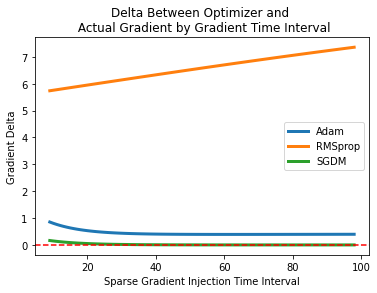

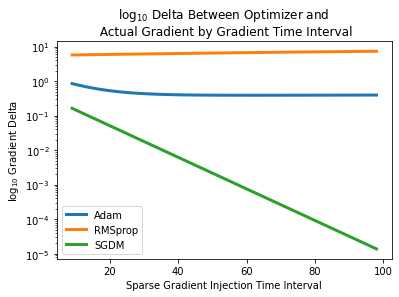

In [11]:
# deltas based upon the time gaps
injection_points = np.arange(10,100).astype(int)-1
injection_amount = 0.2
linewidth = 3
deltas = []
for i in injection_points:
    new_points = [i]
    ips = dps+new_points   #injection points
    ias = das+[injection_amount]*len(new_points)# injection amounts

    s_updates, s_mts, s_vts = opt_plot('sgdm', ips, 
                                       ias, output_terms=True)

    a_updates, a_mts, a_vts = opt_plot('adam', ips, 
                                       ias, output_terms=True)
    
    r_updates, r_mts, r_vts = opt_plot('rmsprop', ips, 
                                       ias, output_terms=True)
    
    adam_delta = a_updates[i] - injection_amount
    rms_delta = r_updates[i] - injection_amount
    sgdm_delta = s_updates[i] - injection_amount
    deltas.append((adam_delta,
                  rms_delta,
                  sgdm_delta))
plt.plot(injection_points, [d[0] for d in deltas],
           label='Adam', linewidth=linewidth)
plt.plot(injection_points, [d[1] for d in deltas],
           label='RMSprop', linewidth=linewidth)
plt.plot(injection_points, [d[2] for d in deltas],
           label='SGDM', linewidth=linewidth)
plt.legend()
plt.title("Delta Between Optimizer and \n Actual Gradient by Gradient Time Interval")
plt.xlabel("Sparse Gradient Injection Time Interval")
plt.ylabel("Gradient Delta")
plt.axhline(0.0, color='red', linestyle='dashed')
plt.gcf().savefig("StaleGradDeltas_VsBaseline.png",dpi=250)
plt.show()

plt.plot(injection_points, [d[0] for d in deltas],
           label='Adam', linewidth=linewidth)
plt.plot(injection_points, [d[1] for d in deltas],
           label='RMSprop', linewidth=linewidth)
plt.plot(injection_points, [d[2] for d in deltas],
           label='SGDM', linewidth=linewidth)
plt.legend()
plt.title("$\log_{10}$ Delta Between Optimizer and \n Actual Gradient by Gradient Time Interval")
plt.xlabel("Sparse Gradient Injection Time Interval")
plt.ylabel("$\log_{10}$ Gradient Delta")
plt.yscale('log')
plt.axhline(0.0, color='red', linestyle='dashed')
plt.gcf().savefig("Log_StaleGradDeltas_VsBaseline.png",dpi=250)
plt.show()


In [12]:
adam_delta

0.39615476780744024